# Figures related to coarse graining in time

Error estimates are done by deviding simulation into 8 independent runs.

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.ndimage import uniform_filter1d
from scipy.stats import sem, t

import analyse

plt.style.use('classic')

/Users/jaehyeok/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jaehyeok/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Loading thermodynamic data

Below we load thermodynamics data from LAMMPS-log files of two consecutive runs (`log.lammps` and `log_2nd.lammps`) into a Pandas Dataframe.

In [2]:
# Load data from first part of run
tic = time.perf_counter()
first_frame = 0
frame_stride = 1   
last_frame = None
time_step = 2e-15
steps_per_printout = 40
print(f'{first_frame=} {frame_stride=} {last_frame=} {steps_per_printout=}')
spns = int(1e-9 / time_step / steps_per_printout / frame_stride)  # Steps per nanosecond
print(f'Steps per nanosecond: {spns = }')
df = analyse.thermo_data_as_dataframe(filename='../../log-file/T380_L35.944/log.lammps',
                                      time_step=time_step,
                                      first_frame=first_frame,
                                      stride_frame=frame_stride,
                                      last_frame=last_frame)
toc = time.perf_counter()
print(f'Wallclock time to load data: {toc-tic} s')

first_frame=0 frame_stride=1 last_frame=None steps_per_printout=40
Steps per nanosecond: spns = 12500
Wallclock time to load data: 6.6113947500000005 s


In [3]:
# Load data from 2nd part of run
join_trajectories = True
if join_trajectories:
    tic = time.perf_counter()
    df_2nd = analyse.thermo_data_as_dataframe(filename='../../log-file/T380_L35.944/log_2nd.lammps',
                                              time_step=time_step,
                                              first_frame=first_frame,
                                              stride_frame=frame_stride,
                                              last_frame=last_frame)
    df_2nd['Time'] = df_2nd.Time + df.Time.max()
    df_2nd.head()
    df = pd.concat([df, df_2nd], axis=0)
    toc = time.perf_counter()
    print(f'Wallclock time to load data: {toc-tic} s')

Wallclock time to load data: 9.876580041999999 s


In [4]:
# Compute inter-molecular energy (between molecules)
df['E_inter'] = df.PotEng - df.E_mol

In [5]:
df.head()

,Time,Step,Temp,Press,PotEng,KinEng,E_vdwl,E_coul,E_mol,Volume,Density,c_virial,E_inter
0,0.000000e+00,0.0,344.93695,-26171.19600,5196.6258,4111.7379,-647.60531,2486.3671,6072.3676,46438.611,1.02942,-30218.6240,-875.7418
1,8.000000e-14,40.0,384.74831,-1813.19590,5029.1247,4586.2996,-393.51470,2504.6959,5631.3149,46438.611,1.02942,-6327.7625,-602.1902
2,1.600000e-13,80.0,386.35782,2081.59420,4969.0675,4605.4855,-359.18030,2485.0399,5558.2705,46438.611,1.02942,-2451.8581,-589.2030
3,2.400000e-13,120.0,386.06626,-548.78717,4866.6535,4602.0099,-478.21544,2501.6095,5557.8171,46438.611,1.02942,-5078.8183,-691.1636
4,3.200000e-13,160.0,376.68499,2197.93110,5051.6645,4490.1828,-390.06892,2511.7764,5645.6552,46438.611,1.02942,-2222.0219,-593.9907


In [6]:
df.tail()

,Time,Step,Temp,Press,PotEng,KinEng,E_vdwl,E_coul,E_mol,Volume,Density,c_virial,E_inter
3355440,4.684352e-07,134217600.0,381.98868,-811.602090,4984.2768,4553.4042,-394.44657,2497.7761,5591.3391,46438.611,1.02942,-5293.7877,-607.0623
3355441,4.684353e-07,134217640.0,384.92741,-419.057880,5000.6772,4588.4345,-371.77400,2506.8891,5575.3857,46438.611,1.02942,-4935.7260,-574.7085
3355442,4.684354e-07,134217680.0,386.93038,-274.394230,4967.5447,4612.3105,-363.56890,2499.7962,5542.2153,46438.611,1.02942,-4814.5648,-574.6706
3355443,4.684354e-07,134217720.0,381.33474,640.577070,5004.1322,4545.6090,-368.62174,2498.6347,5583.8211,46438.611,1.02942,-3833.9353,-579.6889
3355444,4.684355e-07,134217728.0,385.60780,-39.797283,5033.7336,4596.5450,-383.16558,2495.5294,5631.6976,46438.611,1.02942,-4564.4489,-597.9640


In [7]:
print(f'Trajectory of {df.Time.max()/1e-9} ns')

Trajectory of 468.435456 ns


## Analyses of boxcar averages

### Figure 4(a)

In [8]:
t_shift = df.Time*1e9-21  # Shifted time ("edged" are not computed correctly)

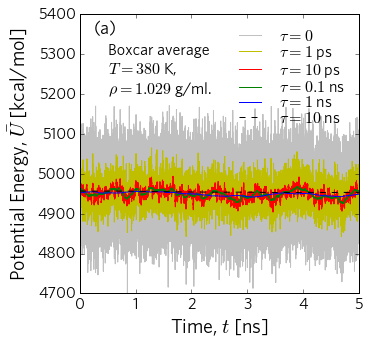

In [35]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(t_shift, df.PotEng, '-', color='silver', label=r'$\tau=0$')
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns/1000)), 'y-', label=r'$\tau=1$ ps')
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns/100)), 'r-', label=r'$\tau=10$ ps')
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns/10)), 'g-', label=r'$\tau=0.1$ ns')
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns)), 'b-', label=r'$\tau=1$ ns')
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns)*10), 'k--', label=r'$\tau=10$ ns')
plt.legend(frameon=False, labelspacing=0.01, fontsize=16)
plt.xlabel(r'Time, $t$ [ns]',fontsize=20)
plt.ylabel(r'Potential Energy, $\bar U$ [kcal/mol]',fontsize=20)
plt.text(0.5, 5200, 'Boxcar average\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.',fontsize=16)
# Put (a) in the upper left corner
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes, fontsize=18)
plt.xlim(0, 5)
plt.ylim(4700, 5400)
plt.savefig('boxcar.pdf', bbox_inches='tight')
plt.savefig('boxcar.png', bbox_inches='tight')

### Figure 4(b)

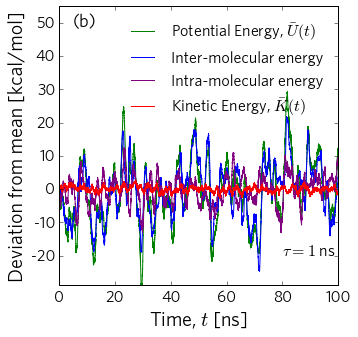

In [34]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(t_shift, uniform_filter1d(df.PotEng, int(spns))-df.PotEng.mean(), 'g-', label=r'Potential Energy, $\bar U(t)$')
plt.plot(t_shift, uniform_filter1d(df.E_inter, int(spns))-df.E_inter.mean(), 'b-', label=r'Inter-molecular energy')
plt.plot(t_shift, uniform_filter1d(df.E_mol, int(spns))-df.E_mol.mean(), '-', color='purple', label=r'Intra-molecular energy')
plt.plot(t_shift, uniform_filter1d(df.KinEng, int(spns))-df.KinEng.mean(), 'r-', label=r'Kinetic Energy, $\bar K(t)$')
plt.xlabel(r'Time, $t$ [ns]', fontsize=20)
plt.ylabel(r'Deviation from mean [kcal/mol]', fontsize=20)
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
plt.text(80, -20, r'$\tau=1$ ns', fontsize=16)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes, fontsize=18)
plt.xlim(0, 100)
plt.ylim(-29, 55)
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.savefig('boxcar_energy.pdf', bbox_inches='tight')
plt.savefig('boxcar_energy.png', bbox_inches='tight')

### Figure 4(c)

59.98063798289096
28.145155888217676
59.089076131091645
58.51167044926403


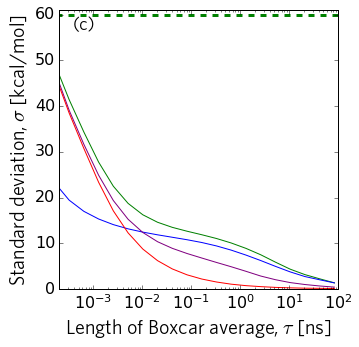

In [33]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
def plot_curve(data, **kwarks):
    """ Compute standard deviation of box-car averages and add to plot """
    sigmas = []
    taus = []
    size = 1
    while size < len(data)/10:
        size=size*2
        taus.append(size/spns)
        sigmas.append(uniform_filter1d(data, size).std())
    plt.plot(taus, sigmas, '-', **kwarks)
    zero_level = data.std()
    #plt.plot([1e-4, 1e0], [zero_level]*2, '--', **kwarks)
    print(zero_level)

plot_curve(df.PotEng, color='g', label=r'Potential Energy, $\bar U(t)$')
plot_curve(df.E_inter, color='b', label=r'Inter-molecular energy')
plot_curve(df.E_mol, color='purple', label=r'Intra-molecular energy')
plot_curve(df.KinEng, color='r', label=r'Kinetic Energy, $\bar K(t)$')

zero_level = df.PotEng.std()
plt.plot([1e-4, 1e2], [zero_level]*2, 'g--', lw=3)
plt.ylabel(r'Standard deviation, $\sigma$ [kcal/mol]',fontsize=20)
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")

plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]',fontsize=20)
plt.xscale('log')
plt.ylim(0, 61)
plt.xlim(2e-4,1e2)
#plt.legend(fontsize=16)
#plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.text(0.05, 0.93, '(c)', transform=plt.gca().transAxes,fontsize=18)
#plt.text(5e-1, 25, 'Ortho-terphenyl:\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.')


plt.savefig('boxcar_standard_deviation.pdf', bbox_inches='tight')
plt.savefig('boxcar_standard_deviation.png', bbox_inches='tight')

### Figure 5(a)

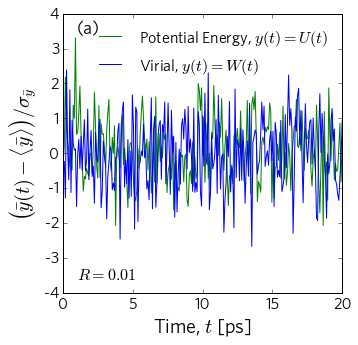

In [32]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
y = df.PotEng-df.PotEng.mean()
plt.plot(t_shift*1e3, y/np.std(y), 'g-', label=r'Potential Energy, $y(t) = U(t)$')
y = df.c_virial-df.c_virial.mean()
plt.plot(t_shift*1e3, y/np.std(y), 'b-', label=r'Virial, $y(t) = W(t)$')
plt.xlabel(r'Time, $t$ [ps]', fontsize=20)
plt.ylabel(r'$\left(\bar y(t)-\langle \bar y\rangle\right)/\sigma_{\bar y}$', fontsize=20)
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
#plt.text(0.1, 0.1, r'$\tau=0$ ns', transform=plt.gca().transAxes)
corrcoef = np.corrcoef(df.PotEng, df.c_virial)[0,1]
plt.text(0.05, 0.05, f'$R = {corrcoef:.2f}$', transform=plt.gca().transAxes, ha='left', fontsize=16)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes, fontsize=18)
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.savefig('boxcar_virial_energy_fast.pdf', bbox_inches='tight')
plt.savefig('boxcar_virial_energy_fast.png', bbox_inches='tight')

### Figure 5(b)

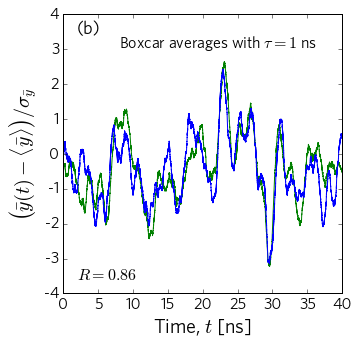

In [31]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
y = uniform_filter1d(df.PotEng, int(spns))-df.PotEng.mean()
plt.plot(t_shift, y/np.std(y), 'g-', label=r'Potential Energy, $\bar y(t) = \bar U(t; \tau)$')
y = uniform_filter1d(df.c_virial, int(spns))-df.c_virial.mean()
plt.plot(t_shift, y/np.std(y), 'b-', label=r'Virial, $\bar y(t) = \bar W(t; \tau)$')
plt.xlabel(r'Time, $t$ [ns]', fontsize=20)
plt.ylabel(r'$\left(\bar y(t)-\langle \bar y\rangle\right)/\sigma_{\bar y}$', fontsize=20)
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
plt.text(0.2, 0.88, r'Boxcar averages with $\tau=1$ ns', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes, fontsize=18)
plt.text(0.05, 0.05, f'$R = 0.86$', transform=plt.gca().transAxes, ha='left', fontsize=16)
plt.xlim(0, 40)
#plt.ylim(-29, 55)
#plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.savefig('boxcar_virial_energy.pdf', bbox_inches='tight')
plt.savefig('boxcar_virial_energy.png', bbox_inches='tight')

### Figure 6(a) and 6(b)

In [36]:
def compute_boxcar_R_gamma(size, blocks=1, block_id=0):
    ''' Compute R and gamma for a part of the trajectory '''
    if not block_id < blocks:
        raise ValueError(f'Reduce {block_id=} to be less than {blocks=}')
    U = np.array(df.PotEng)
    W = np.array(df.c_virial)
    block_len = int(len(U)/blocks)
    first = block_id*block_len
    last = (block_id+1)*block_len
    U = U[first:last]
    W = W[first:last]
    A = uniform_filter1d(U, size)
    B = uniform_filter1d(W, size)
    A = A[size:-size]
    B = B[size:-size]
    R = np.corrcoef(A, B)
    cov = np.cov(A, B)
    return {'R': R[0, 1], 'gamma': cov[0, 1]/A.var()}
compute_boxcar_R_gamma(spns)

{'R': 0.8176082763310751, 'gamma': 6.264484217720644}

In [37]:
def error_bars_by_blocking(size, blocks=8):
    means = compute_boxcar_R_gamma(size)
    R = means['R']
    gamma = means['gamma']

    Rs = [compute_boxcar_R_gamma(size, blocks=blocks, block_id=idx)['R'] for idx in range(blocks)]
    gammas = [compute_boxcar_R_gamma(size, blocks=blocks, block_id=idx)['gamma'] for idx in range(blocks)]

    # Calculate the standard error of the mean (SEM)
    R_err = sem(Rs)
    gamma_err = sem(gammas)

    # Compute the 67% confidence intervals
    confidence_level = 0.67
    degrees_freedom = len(Rs) - 1
    t_multiplier = t.ppf((1 + confidence_level) / 2, degrees_freedom)
    R_err *= t_multiplier
    gamma_err *= t_multiplier

    return {'R': R, 'gamma': gamma, 
            'R_err': R_err, 'gamma_err': gamma_err,
            'size': size, 'blocks': blocks}

error_bars_by_blocking(spns)

{'R': 0.8176082763310751,
 'gamma': 6.264484217720644,
 'R_err': 0.017937187537449988,
 'gamma_err': 0.2641514450949758,
 'size': 12500,
 'blocks': 8}

In [46]:
# Computes R and gamma and error estimates 
#   for different sizes of boxcar averages
Rs, Rs_err = [], []
gammas, gammas_err = [], []
taus = []
size = 1

while size < len(df.PotEng)/16:
    taus.append(size/spns)
    tmp = error_bars_by_blocking(size)
    Rs.append(tmp['R'])
    Rs_err.append(tmp['R_err'])
    gammas.append(tmp['gamma'])
    gammas_err.append(tmp['gamma_err'])
    # pprint(tmp)
    size *= 2

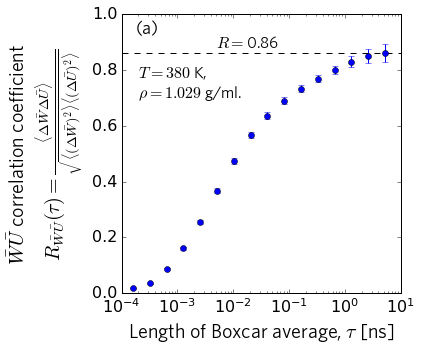

In [47]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
taus_new = taus[:-2]
Rs_new = Rs[:-2]
Rs_err_new = Rs_err[:-2]
plt.errorbar(taus_new, Rs_new, Rs_err_new, fmt='bo')
R_long_time = 0.86
plt.plot([1e-4, 100], [R_long_time]*2, 'k--')
plt.text(5e-3, 0.9, r'$R=$' f'{R_long_time}', va='center',fontsize=16)
plt.xscale('log')
plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]',fontsize=20)
plt.ylabel(r'$\bar W$$\bar U$ correlation coefficient' '\n' r'$R_{\bar W\bar U}(\tau)=\frac{\langle \Delta \bar W\Delta \bar U\rangle}{\sqrt{\langle (\Delta \bar W)^2\rangle\langle (\Delta \bar U)^2\rangle}}$',fontsize=20)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes, fontsize=18)
plt.text(2e-4, 0.7,'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.', fontsize=16)
plt.ylim(0, 1)
plt.xlim(1e-4, 1e1)
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.savefig('boxcar_correlation_coefficient.pdf', bbox_inches='tight')
plt.savefig('boxcar_correlation_coefficient.png', bbox_inches='tight')

In [41]:
taus

[8e-05,
 0.00016,
 0.00032,
 0.00064,
 0.00128,
 0.00256,
 0.00512,
 0.01024,
 0.02048,
 0.04096,
 0.08192,
 0.16384,
 0.32768,
 0.65536,
 1.31072,
 2.62144,
 5.24288,
 10.48576,
 20.97152]

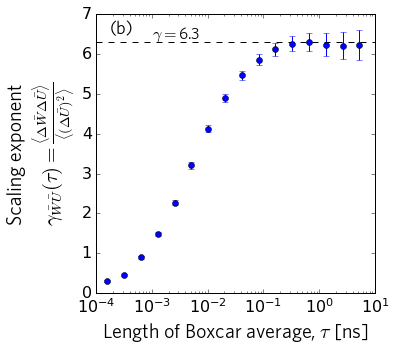

In [51]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
gammas_new = gammas[:-2]
gammas_err_new = gammas_err[:-2]
plt.errorbar(taus_new, gammas_new, gammas_err_new, fmt='bo')
gamma_long_time = 6.3
plt.plot([1e-4, 100], [gamma_long_time]*2, 'k--')
plt.text(1e-3, gamma_long_time+0.2, r'$\gamma=$' f'{gamma_long_time}', va='center',fontsize=16)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes,fontsize=18)
plt.xscale('log')
plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]',fontsize=20)
plt.ylabel(r'Scaling exponent' '\n' r'$\gamma_{\bar W\bar U}(\tau)=\frac{\langle\Delta\bar W\Delta\bar U\rangle}{\langle(\Delta\bar U)^2\rangle}$',fontsize=20)
#plt.text(2e-1, 0.7, r'ortho-terphenyl,' + '\n' + '$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
#plt.ylim(0, 1)
plt.xlim(1e-4, 1e1)
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.savefig('boxcar_scaling_exponent.pdf', bbox_inches='tight')
plt.savefig('boxcar_scaling_exponent.png', bbox_inches='tight')

### Figure 7(a) - 7(c)

In [52]:
def time_correlation_function_one_block(blocks=8, block_id=0, points_per_decade=6):
    if not block_id < blocks:
        raise ValueError(f'Reduce {block_id=} to be less than {blocks=}')
    U = np.array(df.PotEng)
    W = np.array(df.c_virial)
    block_len = int(len(U)/blocks)
    first = block_id*block_len
    last = (block_id+1)*block_len
    U = U[first:last]
    W = W[first:last]
    
    C_UU = analyse.time_correlation(U)
    C_WW = analyse.time_correlation(W)
    C_WU = analyse.time_correlation(W, U)
    
    C_UU_log = analyse.run_avg_log(C_UU, points_per_decade)
    C_WW_log = analyse.run_avg_log(C_WW, points_per_decade)
    C_WU_log = analyse.run_avg_log(C_WU, points_per_decade)    
    t_log = analyse.run_avg_log(df.Time, points_per_decade)
    t_log = t_log[0:len(C_UU_log)]
    
    return {
        't': t_log,
        'C_UU': C_UU_log,
        'C_WW': C_WW_log,
        'C_WU': C_WU_log
    }

time_correlation_function_one_block()

{'t': array([0.000000e+00, 8.000000e-14, 1.600000e-13, 2.400000e-13,
        3.600000e-13, 5.600000e-13, 8.800000e-13, 1.360000e-12,
        2.040000e-12, 3.040000e-12, 4.520000e-12, 6.640000e-12,
        9.760000e-12, 1.440000e-11, 2.120000e-11, 3.116000e-11,
        4.576000e-11, 6.716000e-11, 9.860000e-11, 1.448000e-10,
        2.126000e-10, 3.120800e-10, 4.580800e-10, 6.724000e-10,
        9.870000e-10, 1.448800e-09, 2.126600e-09, 3.121440e-09,
        4.581720e-09, 6.725080e-09, 9.871080e-09, 1.448884e-08,
        2.126676e-08, 3.121536e-08, 4.581796e-08]),
 'C_UU': array([ 3.59630018e+03,  1.29803907e+03,  9.37460693e+02,  7.74567971e+02,
         5.24100115e+02,  3.21903037e+02,  2.35109040e+02,  2.01437452e+02,
         1.89837609e+02,  1.89376680e+02,  1.78951907e+02,  1.73615963e+02,
         1.65208545e+02,  1.57106096e+02,  1.53288271e+02,  1.46509353e+02,
         1.37779275e+02,  1.30042523e+02,  1.20817065e+02,  1.10436092e+02,
         1.01487088e+02,  9.14353366e+01,  

In [53]:
%%time
block_data = []
blocks = 8
for block_id in range(blocks):
    tmp = time_correlation_function_one_block(blocks=blocks, block_id=block_id)
    pprint(tmp)
    block_data.append(tmp)

{'C_UU': array([ 3.59630018e+03,  1.29803907e+03,  9.37460693e+02,  7.74567971e+02,
        5.24100115e+02,  3.21903037e+02,  2.35109040e+02,  2.01437452e+02,
        1.89837609e+02,  1.89376680e+02,  1.78951907e+02,  1.73615963e+02,
        1.65208545e+02,  1.57106096e+02,  1.53288271e+02,  1.46509353e+02,
        1.37779275e+02,  1.30042523e+02,  1.20817065e+02,  1.10436092e+02,
        1.01487088e+02,  9.14353366e+01,  7.69680021e+01,  5.56559469e+01,
        3.05355189e+01,  1.34590220e+01, -1.30748632e+00, -1.03227303e+01,
       -3.25689996e+00, -9.10919997e+00, -4.65848850e+00, -2.80107463e+00,
       -4.55528420e+00,  3.75649737e+00, -1.23012401e+00]),
 'C_WU': array([ 809.26397896,  641.88747299,  407.59000533, 1624.53219587,
       1595.6622273 , 1215.94461806, 1136.37177847, 1186.37564543,
       1105.23263292, 1123.51260835, 1076.35629439, 1023.60818074,
       1011.53152209,  971.09731761,  931.93654263,  926.66432408,
        897.7290301 ,  844.80802199,  783.71300086,  7

{'C_UU': array([ 3.63073888e+03,  1.33593464e+03,  9.71907498e+02,  8.04772155e+02,
        5.55988254e+02,  3.55351687e+02,  2.65042520e+02,  2.30137944e+02,
        2.13301986e+02,  2.05601082e+02,  2.02961784e+02,  1.95154247e+02,
        1.92570049e+02,  1.82771038e+02,  1.77398001e+02,  1.68547199e+02,
        1.58424817e+02,  1.50968218e+02,  1.39919258e+02,  1.27287947e+02,
        1.17421207e+02,  1.01743553e+02,  8.82704154e+01,  7.53256437e+01,
        5.43278123e+01,  3.50196283e+01,  2.14726715e+01, -3.12589448e+00,
       -1.22554955e+01, -4.14362110e+00, -5.20517976e+00, -1.04654531e+01,
        7.18657491e+00, -6.09156040e-01, -4.73004997e+00]),
 'C_WU': array([1061.53160736, 1005.45712118,  855.39525306, 1825.81250493,
       1848.16955789, 1516.51777116, 1356.86398853, 1415.07544937,
       1303.65169405, 1321.55833025, 1303.44245854, 1270.67995678,
       1219.10545511, 1219.25481974, 1159.97729609, 1122.32080587,
       1065.06459431,  992.61054104,  942.1813373 ,  8

In [54]:
t_log = block_data[0]['t']
mean_C_UU = np.mean([block['C_UU'] for block in block_data], axis=0)
mean_C_WU = np.mean([block['C_WU'] for block in block_data], axis=0)
mean_C_WW = np.mean([block['C_WW'] for block in block_data], axis=0)

In [55]:
%%time

# Standard error of mean
sem_C_UU = sem([block['C_UU'] for block in block_data], axis=0)
sem_C_WW = sem([block['C_WW'] for block in block_data], axis=0)
sem_C_WU = sem([block['C_WU'] for block in block_data], axis=0)
sem_C_R = sem([block['C_WU']/np.sqrt(np.abs(block['C_UU']*block['C_WW'])) for block in block_data], axis=0)
sem_C_gamma = sem([block['C_WU']/block['C_UU'] for block in block_data], axis=0)

# Compute the 67% confidence intervals
confidence_level = 0.67
degrees_freedom = len(block_data) - 1
t_multiplier = t.ppf((1 + confidence_level) / 2, degrees_freedom)
print(f'{t_multiplier=}')

# Compute the confidence intervals
C_UU_err = sem_C_UU * t_multiplier
C_WW_err = sem_C_WW * t_multiplier
C_WU_err = sem_C_WU * t_multiplier
C_R_err = sem_C_R * t_multiplier
C_gamma_err = sem_C_gamma * t_multiplier

t_multiplier=1.046766724664122
CPU times: user 4.68 ms, sys: 1.66 ms, total: 6.34 ms
Wall time: 5.44 ms


[164.61255043   0.64370115   0.47463356]


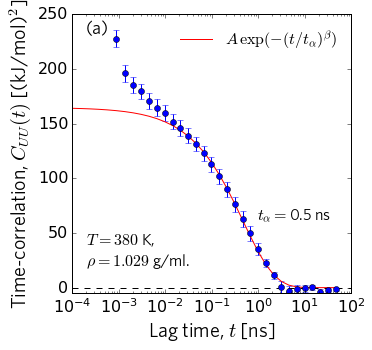

In [94]:
# Plot energy-energy correlation function

# Fit stretch exponential to the long-time tail of C_UU (below max_y_value)
max_y_value = 150
def stretched_exponential(t, A, beta, t_alpha):
    return A*np.exp(-(t/t_alpha)**beta)
# Find long tail data
long_tail = mean_C_UU < max_y_value
pguess = [150, 0.8, 0.8]
popt, pcov = scipy.optimize.curve_fit(stretched_exponential, t_log[long_tail]*1e9, mean_C_UU[long_tail], p0=pguess)
print(popt)
A, beta, t_alpha = popt


# Plot energy-energy correlation function
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(t_log*1e9, mean_C_UU, C_UU_err, fmt='bo')
#plt.plot(t_log*1e9, stretched_exponential(t_log*1e9, *pguess), 'r--', label='guess')
plt.plot(t_log*1e9, stretched_exponential(t_log*1e9, *popt), 'r-', label=r'$A\,\exp(-(t/t_\alpha)^\beta)$')
plt.xscale('log')
plt.text(t_alpha*2, A/2.5, r'$t_\alpha = $' f'{t_alpha:.1g} ns', va='center',fontsize=16)
plt.plot([1e-4, 100], [0]*2, 'k--')
plt.ylim(-5, 250)
plt.xlim(1e-4, 100)
plt.ylabel(r'Time-correlation, $C_{UU}(t)$ [(kJ/mol)$^2$]',fontsize=20)
plt.xlabel(r'Lag time, $t$ [ns]',fontsize=20)
plt.text(0.05, 0.1,'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes,fontsize=18)
plt.legend(frameon=False, loc='upper right', numpoints=1,fontsize=16)
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.savefig('CUU_time_correlation.pdf', bbox_inches='tight')
plt.savefig('CUU_time_correlation.png', bbox_inches='tight')
plt.show()

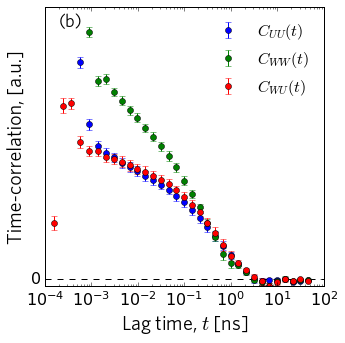

In [60]:
plt.figure(figsize=(5, 5))
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(t_log*1e9, mean_C_UU/100, C_UU_err/100, fmt='bo', label=r'$C_{UU}(t)$')
plt.errorbar(t_log*1e9, mean_C_WW/5000, C_WW_err/5000, fmt='go', label=r'$C_{WW}(t)$')
plt.errorbar(t_log*1e9, mean_C_WU/600, C_WU_err/600, fmt='ro', label=r'$C_{WU}(t)$')
plt.plot([1e-4, 100], [0]*2, 'k--')
plt.xscale('log')
plt.ylim(-0.1, 4)
plt.xlim(1e-4, 100)
plt.yticks([0])
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes,fontsize=18)

plt.ylabel(r'Time-correlation, [a.u.]',fontsize=20)
plt.xlabel(r'Lag time, $t$ [ns]',fontsize=20)
plt.legend(frameon=False, loc='upper right', numpoints=1,fontsize=16)
plt.savefig('all_time_correlation.pdf', bbox_inches='tight')
plt.savefig('all_time_correlation.png', bbox_inches='tight')
plt.show()

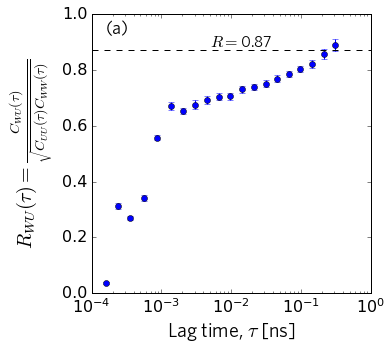

In [93]:
# Time-dependent correlation coefficient
last = 24

plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
mean_R = mean_C_WU/np.sqrt(np.abs(mean_C_UU*mean_C_WW))
plt.errorbar(t_log[:last-2]*1e9, mean_R[:last-2], C_R_err[:last-2], fmt='bo', label=r'$R_{WU}(\tau)$')
plt.plot([1e-4, 100], [R_long_time]*2, 'k--')
plt.text(5e-3, 0.9, r'$R=$' f'{R_long_time}', va='center',fontsize=16)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes,fontsize=18)

plt.xscale('log')
plt.ylim(0, 1.0)
plt.xlim(1e-4, 1)
plt.ylabel(r'$R_{WU}(\tau)=\frac{C_{WU}(\tau)}{\sqrt{C_{UU}(\tau)C_{WW}(\tau)}}$',fontsize=20)
plt.xlabel(r'Lag time, $\tau$ [ns]',fontsize=20)
plt.savefig('R_time_correlation.pdf', bbox_inches='tight')
plt.savefig('R_time_correlation.png', bbox_inches='tight')

plt.show()

In [73]:
t_log*1e9

array([0.000000e+00, 8.000000e-05, 1.600000e-04, 2.400000e-04,
       3.600000e-04, 5.600000e-04, 8.800000e-04, 1.360000e-03,
       2.040000e-03, 3.040000e-03, 4.520000e-03, 6.640000e-03,
       9.760000e-03, 1.440000e-02, 2.120000e-02, 3.116000e-02,
       4.576000e-02, 6.716000e-02, 9.860000e-02, 1.448000e-01,
       2.126000e-01, 3.120800e-01, 4.580800e-01, 6.724000e-01,
       9.870000e-01, 1.448800e+00, 2.126600e+00, 3.121440e+00,
       4.581720e+00, 6.725080e+00, 9.871080e+00, 1.448884e+01,
       2.126676e+01, 3.121536e+01, 4.581796e+01])

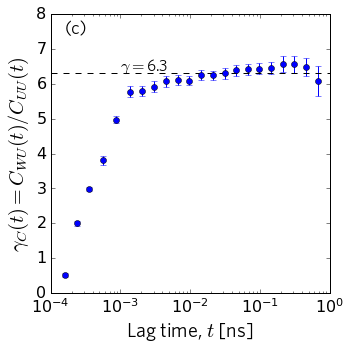

In [74]:
# Time-dependent scaling exponent
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(t_log[:last]*1e9, mean_C_WU[:last]/mean_C_UU[:last], C_gamma_err[:last], fmt='bo', label=r'$\gamma_{WU}(\tau)$')
plt.plot([1e-4, 100], [gamma_long_time]*2, 'k--')
plt.text(1e-3, gamma_long_time+0.2, r'$\gamma = $' f'{gamma_long_time}', va='center',fontsize=16)
plt.xscale('log')
plt.text(0.05, 0.93, '(c)', transform=plt.gca().transAxes,fontsize=18)
plt.ylim(0, 8)
plt.xlim(1e-4, 1)
plt.ylabel(r'$\gamma_{C}(t)=C_{WU}(t)/C_{UU}(t)$',fontsize=20)
plt.xlabel(r'Lag time, $t$ [ns]',fontsize=20)
plt.savefig('gamma_WU_time_correlation.pdf', bbox_inches='tight')
plt.savefig('gamma_WU_time_correlation.png', bbox_inches='tight')
plt.show()

### Figure 8(a) and 8(b)

In [75]:
%%time
def frequency_responce_one_block(blocks=8, block_id=0, points_per_decade=6):
    if not block_id < blocks:
        raise ValueError(f'Reduce {block_id=} to be less than {blocks=}')
    U = np.array(df.PotEng)
    W = np.array(df.c_virial)
    block_len = int(len(U)/blocks)
    first = block_id*block_len
    last = (block_id+1)*block_len
    U = U[first:last]
    W = W[first:last]
    
    dt = float(df.reset_index().Time[1] - df.reset_index().Time[0])*1e9  # Time step in ns
    
    omega, mu_UU = analyse.frequency_dependent_response(U, U, dt=dt)
    _, mu_WW = analyse.frequency_dependent_response(W, W, dt=dt)
    _, mu_UW = analyse.frequency_dependent_response(U, W, dt=dt)
    
    omega_log = analyse.run_avg_log(omega, points_per_decade)
    mu_UU_log = analyse.run_avg_log(mu_UU, points_per_decade)
    mu_WW_log = analyse.run_avg_log(mu_WW, points_per_decade)
    mu_UW_log = analyse.run_avg_log(mu_UW, points_per_decade)
    
    return {
        'omega': omega_log,
        'mu_UU': mu_UU_log,
        'mu_WW': mu_WW_log,
        'mu_UW': mu_UW_log
    }
    
frequency_responce_one_block()

CPU times: user 1.65 s, sys: 1.39 s, total: 3.04 s
Wall time: 4.52 s


{'omega': array([0.00000000e+00, 1.07305092e-01, 2.14610185e-01, 3.21915277e-01,
        4.82872916e-01, 7.51135647e-01, 1.18035602e+00, 1.82418657e+00,
        2.73627986e+00, 4.07759351e+00, 6.06273773e+00, 8.90632268e+00,
        1.30912213e+01, 1.93149166e+01, 2.84358495e+01, 4.17953335e+01,
        6.13785129e+01, 9.00826251e+01, 1.32253526e+02, 1.94222217e+02,
        2.85163283e+02, 4.18597166e+02, 6.14428960e+02, 9.01899302e+02,
        1.32387658e+03, 1.94329522e+03, 2.85243762e+03, 4.18683010e+03,
        6.14552360e+03, 9.02044164e+03, 1.32402144e+04, 1.94340790e+04,
        2.85253956e+04, 4.18695886e+04, 6.14562554e+04]),
 'mu_UU': array([-4745.42080987-1.73372428e-12j, -4747.31800705+8.50399736e-01j,
        -4751.27301197+2.90066388e+00j, -4762.36426911+1.26588242e+01j,
        -4739.76975781+3.08819194e+01j, -4758.17583811+2.90479829e+01j,
        -4737.54046722+5.58828975e+01j, -4694.19131995+7.15856902e+01j,
        -4681.94082392+1.00096631e+02j, -4635.43088667+5.359

In [76]:
%%time
mu_blocks = []
for block_id in range(blocks):
    tmp = frequency_responce_one_block(blocks=blocks, block_id=block_id)
    # pprint(tmp)
    mu_blocks.append(tmp)

CPU times: user 12.8 s, sys: 5.44 s, total: 18.3 s
Wall time: 19.3 s


In [77]:
mu_blocks[2]['mu_WW'][0]

(-1799132.103812022-1.0040821507573128e-09j)

In [78]:
# Remove a zero, to avoid 1/0
mu_blocks[3]['mu_WW'][0] = mu_blocks[2]['mu_WW'][0]

In [79]:
# Standard error of mean
sem_mu_UU_imag = sem([np.imag(block['mu_UU']) for block in mu_blocks], axis=0)
sem_mu_WW_imag = sem([np.imag(block['mu_WW']) for block in mu_blocks], axis=0)
sem_mu_WU_imag = sem([np.imag(block['mu_UW']) for block in mu_blocks], axis=0)
tmp = [np.imag(block['mu_UW'])/np.sqrt(np.abs(np.imag(block['mu_UU'])*np.imag(block['mu_WW']))) for block in mu_blocks]
sem_mu_R = sem(tmp, axis=0)
sem_mu_gamma = sem([np.imag(block['mu_UW'])/np.imag(block['mu_UU']) for block in mu_blocks], axis=0)

# Compute the confidence intervals
mu_UU_imag_err = sem_mu_UU_imag * t_multiplier
mu_WW_imag_err = sem_mu_WW_imag * t_multiplier
mu_WU_imag_err = sem_mu_WU_imag * t_multiplier
mu_R_err = sem_mu_R * t_multiplier
mu_gamma_err = sem_mu_gamma * t_multiplier

In [80]:
omega_log = mu_blocks[0]['omega']
mu_UU_log = np.mean([block['mu_UU'] for block in mu_blocks], axis=0)
mu_WW_log = np.mean([block['mu_WW'] for block in mu_blocks], axis=0)
mu_UW_log = np.mean([block['mu_UW'] for block in mu_blocks], axis=0)

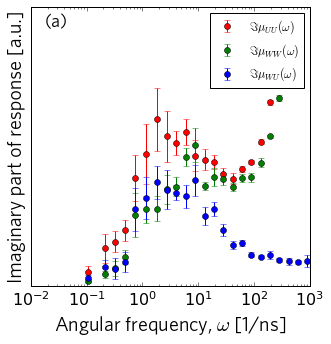

In [81]:
# Plot frequency-dependent response
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(omega_log, np.imag(mu_UU_log)/100, mu_UU_imag_err/100, fmt='ro', label=r'$\Im\mu_{UU}(\omega)$')
plt.errorbar(omega_log, np.imag(mu_WW_log)/10000, mu_WW_imag_err/10000, fmt='go', label=r'$\Im\mu_{WW}(\omega)$')
plt.errorbar(omega_log, np.imag(mu_UW_log)/1000, mu_WU_imag_err/1000, fmt='bo', label=r'$\Im\mu_{WU}(\omega)$')
plt.plot([0, 1e13], [0, 0], 'k--')
plt.xlim(1e-2,1e3)
plt.ylim(0, 1)
plt.yticks([])
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes,fontsize=18)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]',fontsize=20)
plt.ylabel(r'Imaginary part of response [a.u.]',fontsize=20)
plt.legend(numpoints=1)
plt.savefig('all_response.pdf', bbox_inches='tight')
plt.savefig('all_response.png', bbox_inches='tight')
plt.show()

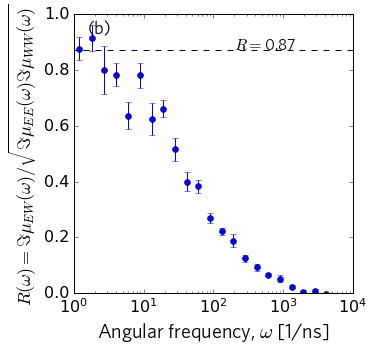

In [89]:
skip = 5

# Plot frequency-dependent correlation coefficient
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(omega_log[skip:], np.imag(mu_UW_log[skip:])/np.sqrt(np.imag(mu_UU_log[skip:])*np.imag(mu_WW_log[skip:])), mu_R_err[skip:], fmt='bo', label=r'$R(\omega)$')
R_long_time = 0.87
plt.plot([1e-2, 1e4], [R_long_time]*2, 'k--')
plt.text(2e2, R_long_time+0.02, r'$R=$' f'{R_long_time}', va='center',fontsize=16)
plt.xlim(1e0,1e4)
plt.ylim(0, 1)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]',fontsize=20)
plt.ylabel(r'$R(\omega)=\Im\mu_{EW}(\omega)/\sqrt{\Im\mu_{EE}(\omega)\Im\mu_{WW}(\omega)}$',fontsize=18)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes,fontsize=18)
plt.savefig('R_response.pdf', bbox_inches='tight')
plt.savefig('R_response.png', bbox_inches='tight')
plt.show()

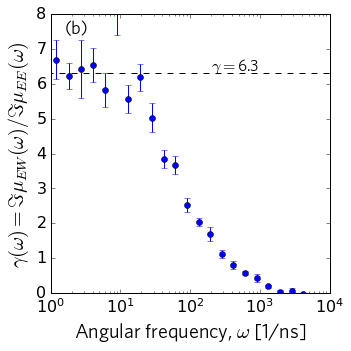

In [86]:
# Plot the frequency dependent scaling exponent
plt.figure(figsize=(5, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontname="DejaVu Sans")
plt.yticks(fontname="DejaVu Sans")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.errorbar(omega_log[skip:], np.imag(mu_UW_log[skip:])/np.imag(mu_UU_log[skip:]), mu_gamma_err[skip:], fmt='bo', label=r'$\gamma(\omega)$')
plt.plot([1e-2, 1e4], [gamma_long_time]*2, 'k--')
plt.text(2e2, gamma_long_time+0.2, r'$\gamma=$' f'{gamma_long_time}', va='center',fontsize=16)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes,fontsize=18)
plt.xlim(1e0,1e4)
plt.ylim(0, 8)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]',fontsize=20)
plt.ylabel(r'$\gamma(\omega)=\Im\mu_{EW}(\omega)/\Im\mu_{EE}(\omega)$',fontsize=20)
plt.savefig('gamma_WU_response.pdf', bbox_inches='tight')
plt.savefig('gamma_WU_response.png', bbox_inches='tight')
plt.show()